### Step 1:

In [22]:
%cd "/Users/rebeccaglick/Desktop/SPRING 2025/NLU/Project/knowledge_graph_creation/data/"
import json
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Load data
with open('diabetes_subset.json', 'r') as f:
    data = json.load(f)

# Convert desired number of items in LangChain document - to start, I am using the first 50
# Each entry has contexts, long_answer, and ground truth final_decision
items = list(data.items())

documents = []
for pmid, entry in data.items():
    context = " ".join(entry["CONTEXTS"])
    long_answer = entry["LONG_ANSWER"]
    full_text = f"Context: {context}\n\nConclusion: {long_answer}"
    documents.append(Document(page_content=full_text, metadata={"pmid": pmid}))

# Create embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Build FAISS vector store/database
vectorstore = FAISS.from_documents(documents, embedding_model)

# Save locally for later
vectorstore.save_local("faiss_index_diabetes_subset")

/opt/anaconda3/envs/kg/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/rebeccaglick/Desktop/SPRING 2025/NLU/Project/knowledge_graph_creation/data


### Step 2:

In [23]:
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOllama
from langchain.embeddings import HuggingFaceEmbeddings

# 1. Reload the FAISS vector store
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.load_local("faiss_index_diabetes_subset", embedding_model, allow_dangerous_deserialization=True)

# 2. Create retriever and specify how many documents you want it to pull as context
retriever = vectorstore.as_retriever(search_kwargs={"k":2})

# 3. Connect to Ollama running LLaMA 3.2
llm = ChatOllama(model="llama3.2")

# 4. Prompt function
def create_query_to_answer_using_abstracts(question, abstract):
    return f"""
    Using this information {abstract}

    Answer the following quesiton with yes, no, or maybe. Do not elaborate. Only answer the question with one word. The answer must be yes, no, or maybe: {question} 
    """

# 5. Answer generator
def generate_answers_using_abstracts(question):
    # Step 1: Retrieve top-k documents from FAISS
    retrieved_docs = retriever.get_relevant_documents(question)

    # Step 2: Build full_text from the retrieved documents (includes context + long_answer)
    full_text = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # Step 3: Use function to form the prompt
    prompt = create_query_to_answer_using_abstracts(question, full_text)
    # Pass prompt to LLM
    response = llm.invoke(prompt)

    # Step 4: Return full output and extracted first word
    raw_output = response.content.strip()
    first_word = raw_output.split()[0].rstrip('.').lower()
    return first_word, raw_output

### Step 3:

In [24]:
# 6. Loop over dataset items
correct_retrievals = 0
correct_predictions = 0
predictions = []

for pmid, entry in items:
    question = entry["QUESTION"]
    truth = entry["final_decision"]

    answer, full_response = generate_answers_using_abstracts(question)
    retrieved_docs = retriever.get_relevant_documents(question)
    retrieved_pmids = [doc.metadata.get("pmid", "N/A") for doc in retrieved_docs]
    predictions.append({
        "pmid": pmid,
        "question": question,
        "truth": truth,
        "answer": answer,
        "full_response": full_response
    })

    # Print results
    print("\n" + "-" * 60)
    print(f"PMID: {pmid}")
    print(f"Question: {question}")
    print(f"Ground Truth: {truth}")
    print(f"Full LLM Output: {full_response}")
    print(f"Answer Used for Evaluation: {answer}")
    print(f"Retrieved PMIDs: {retrieved_pmids}")

    # Count a successful retrieval if the correct pmid is among the retrieved
    if str(pmid) in retrieved_pmids:
        correct_retrievals += 1
        print("Pulled the correct abstract.")

    if answer.split()[0] == truth:
        print("Correct prediction has been made.")
        correct_predictions += 1

    print("-" * 60)

print("-" * 60)
print("-" * 60)
print("-" * 60)

# Summary of evaluation 
print("\n--- Retrieval Summary ---")
print(f"Correct document retrieved {correct_retrievals} out of {len(items)} times.")
print(f"Retrieval accuracy: {correct_retrievals / len(items):.2f}")

print("\n--- Evaluation Summary ---")
print(f"Total examples: {len(predictions)}")
print(f"Correct predictions: {correct_predictions}")
print(f"Model accuracy: {correct_predictions / len(predictions):.2f}")

# Extract just the predicted answers
predicted_labels = [entry["answer"] for entry in predictions]

# Extract predictions and ground truths
predicted_labels = [entry["answer"] for entry in predictions]
ground_truth_labels = [entry["truth"] for entry in predictions]

# Print comma-separated lists
print("\nGround Truth Labels:")
print(", ".join(ground_truth_labels))

print("\nPredicted Labels:")
print(", ".join(predicted_labels))



------------------------------------------------------------
PMID: 15703931
Question: Does diabetes mellitus influence the efficacy of FDG-PET in the diagnosis of cervical cancer?
Ground Truth: no
Full LLM Output: Yes
Answer Used for Evaluation: yes
Retrieved PMIDs: ['15703931', '12145243']
Pulled the correct abstract.
------------------------------------------------------------

------------------------------------------------------------
PMID: 27456836
Question: Do Electrochemiluminescence Assays Improve Prediction of Time to Type 1 Diabetes in Autoantibody-Positive TrialNet Subjects?
Ground Truth: yes
Full LLM Output: Yes.
Answer Used for Evaluation: yes
Retrieved PMIDs: ['27456836', '12145243']
Pulled the correct abstract.
Correct prediction has been made.
------------------------------------------------------------

------------------------------------------------------------
PMID: 22720085
Question: Does insulin resistance drive the association between hyperglycemia and cardiova

In [4]:
# k=1, 13/23, 57% accuracy
# k=2, 14/23, 61% accuracy
# k=3, 15/23, 65% accuracy
# k=4, 15/23, 65% accuracy
print("Predictions: ", valid_answers)

truth = []
for pmid, entry in data.items():
    truth.append(entry["final_decision"].lower())

print("Ground truth: ", truth)

Predictions:  ['yes', 'yes', 'yes', 'yes', 'maybe', 'yes', 'maybe', 'no', 'maybe', 'yes', 'no', 'yes', 'maybe', 'yes', 'yes', 'no', 'maybe', 'no', 'yes', 'yes', 'maybe', 'maybe', 'yes']
Ground truth:  ['no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'maybe', 'yes', 'no', 'no', 'yes']


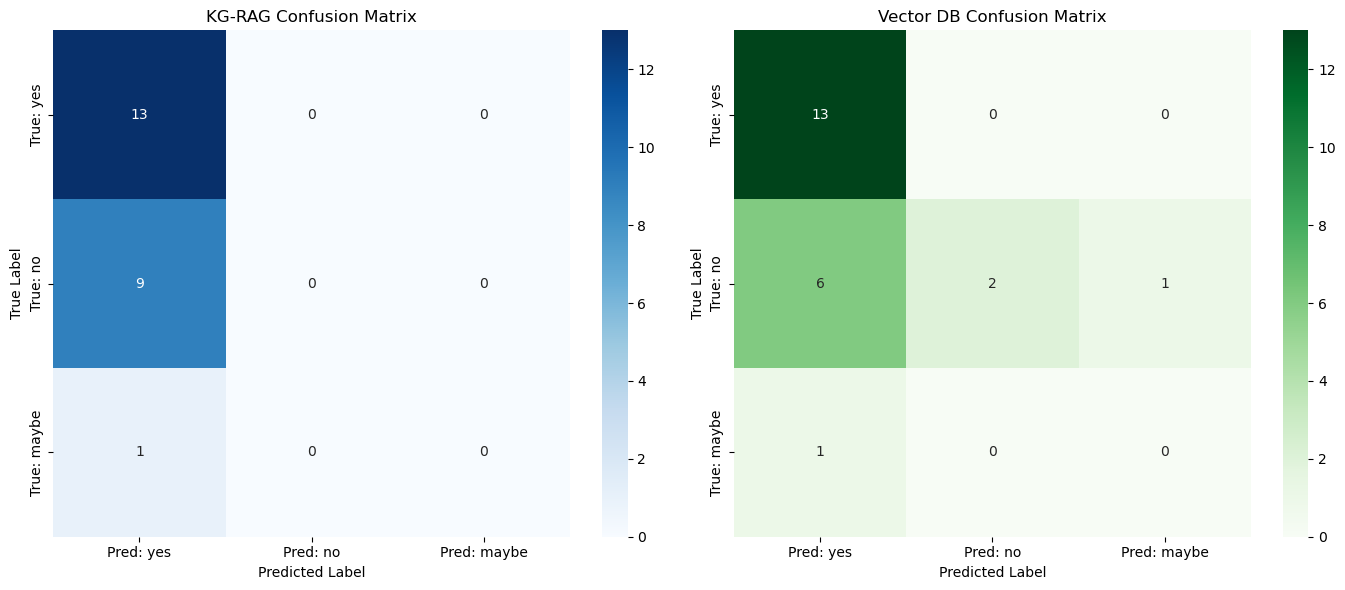

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# --- VECTOR DB DATA ---
vd_predictions = [
    'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
    'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
    'yes', 'yes', 'yes', 'yes', 'maybe', 'yes', 'yes'
]

# --- KNOWLEDGE GRAPH DATA (FILL IN YOUR OWN LATER) ---
kg_predictions = ['yes'] * 23

# --- SHARED GROUND TRUTH LABELS ---
ground_truth = [
    'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes',
    'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no',
    'no', 'no', 'maybe', 'yes', 'no', 'no', 'yes'
]

# --- COMMON SETUP ---
labels = ['yes', 'no', 'maybe']

# Confusion matrix for vector DB
vd_conf_matrix = confusion_matrix(ground_truth, vd_predictions, labels=labels)
vd_conf_df = pd.DataFrame(vd_conf_matrix,
    index=[f"True: {l}" for l in labels],
    columns=[f"Pred: {l}" for l in labels]
)

# Confusion matrix for knowledge graph
kg_conf_matrix = confusion_matrix(ground_truth, kg_predictions, labels=labels)
kg_conf_df = pd.DataFrame(kg_conf_matrix,
    index=[f"True: {l}" for l in labels],
    columns=[f"Pred: {l}" for l in labels]
)

# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(kg_conf_df, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("KG-RAG Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(vd_conf_df, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Vector DB Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [23, 3]

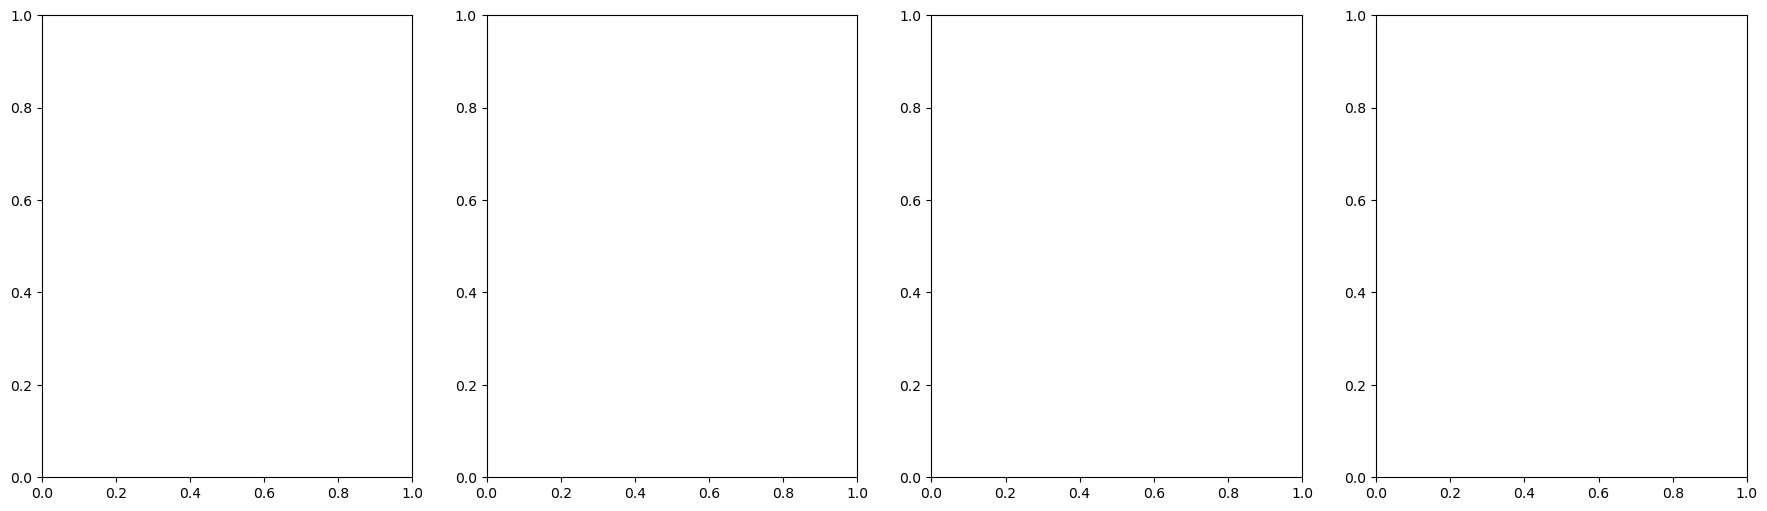

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# --- SHARED GROUND TRUTH LABELS ---
#ground_truth = [
#    'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes',
#    'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no',
#    'no', 'no', 'maybe', 'yes', 'no', 'no', 'yes'
#]

# --- VECTOR DB PREDICTIONS ---
vd_preds = {
    "FAISS Vector Store and RAG LLM": np.array([
        [9, 3, 1], # True = Yes
        [2, 5, 2], # True = No
        [1, 0, 0], # True = Maybe
    ])
}

# --- KNOWLEDGE GRAPH PREDICTIONS ---
kg_preds = {
    "GPT-4o-mini & LlaMA 3.2 RAG LLM": np.array([
        [6, 7, 0], # True = Yes
        [1, 6, 2], # True = No
        [0, 1, 0], # True = Maybe
    ]),

    "GPT-4o-mini KG & RAG LLM": np.array([
        [1, 1, 11], # True = Yes
        [0, 1, 8], # True = No
        [0, 0, 1], # True = Maybe
    ]),

    "LlaMA-3.2 KG & RAG LLM": np.array([
        [5, 7, 1], # True = Yes
        [4, 4, 1], # True = No
        [0, 1, 0], # True = Maybe 
    ])
}

# --- LABEL SETUP ---
labels = ['yes', 'no', 'maybe']
column_labels = [f"Pred: {l}" for l in labels]

# Create the figure and gridspec for subplots
fig, axes = plt.subplots(1, 4, figsize=(22, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

# Use consistent color scale
all_preds = list(kg_preds.values()) + [vd_predictions]
vmin, vmax = 0, max(confusion_matrix(ground_truth, p, labels=labels).max() for p in all_preds)

# Define colormap
cmap = "Blues"

# Plot the three KG confusion matrices
for i, (ax, (title, preds)) in enumerate(zip(axes[:3], kg_preds.items())):
    cm = confusion_matrix(ground_truth, preds, labels=labels)
    df = pd.DataFrame(cm, index=labels, columns=column_labels)
    sns.heatmap(df, annot=True, fmt="d", cmap=cmap, ax=ax, square=True, cbar=False,
                vmin=vmin, vmax=vmax, yticklabels=(labels if i == 0 else []))
    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    if i == 0:
        ax.set_ylabel("True Value")
    else:
        ax.set_ylabel("")

# Plot the vector DB confusion matrix with external colorbar
cm = confusion_matrix(ground_truth, vd_predictions, labels=labels)
df = pd.DataFrame(cm, index=labels, columns=column_labels)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
sns.heatmap(df, annot=True, fmt="d", cmap=cmap, ax=axes[3], square=True,
            cbar=True, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax,
            yticklabels=[])
axes[3].set_title("Vector DB Confusion Matrix")
axes[3].set_xlabel("Predicted Label")
axes[3].set_ylabel("")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


/var/folders/dh/9bsy_n5n2v9_ppjwbvg9fwdw0000gn/T/ipykernel_53633/449501418.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # layout first


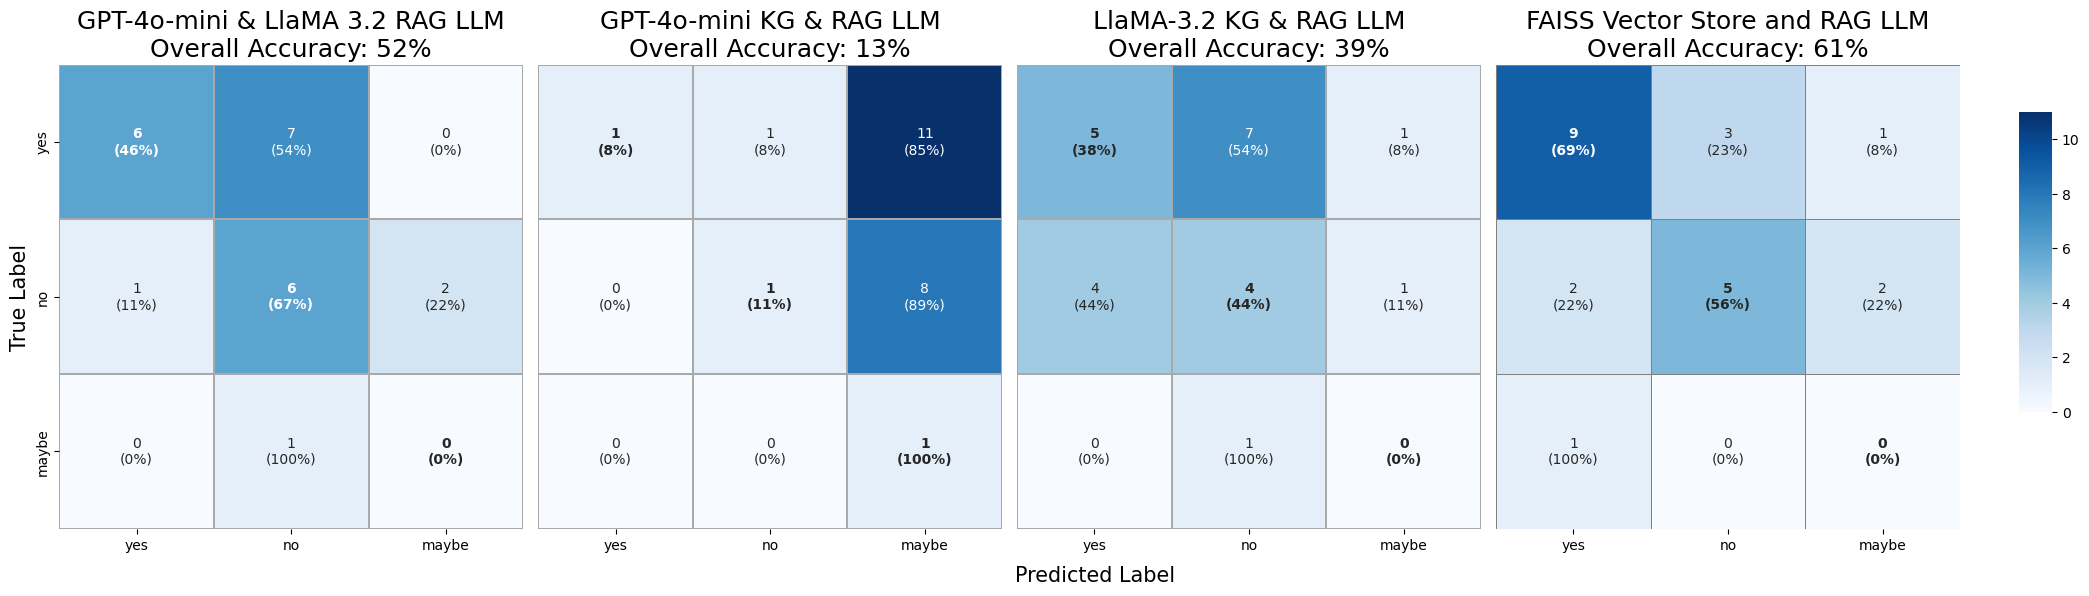

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Confusion Matrices (Precomputed) ---
vd_preds = {
    "FAISS Vector Store and RAG LLM": np.array([
        [9, 3, 1],
        [2, 5, 2],
        [1, 0, 0],
    ])
}

kg_preds = {
    "GPT-4o-mini & LlaMA 3.2 RAG LLM": np.array([
        [6, 7, 0],
        [1, 6, 2],
        [0, 1, 0],
    ]),
    "GPT-4o-mini KG & RAG LLM": np.array([
        [1, 1, 11],
        [0, 1, 8],
        [0, 0, 1],
    ]),
    "LlaMA-3.2 KG & RAG LLM": np.array([
        [5, 7, 1],
        [4, 4, 1],
        [0, 1, 0],
    ])
}

# --- Labels Setup ---
labels = ['yes', 'no', 'maybe']
column_labels = [f"{l}" for l in labels]

# --- Helper to build annotation matrix ---
def make_annot_matrix(cm):
    total_per_row = cm.sum(axis=1, keepdims=True)
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = (count / total_per_row[i][0] * 100) if total_per_row[i][0] > 0 else 0
            annot[i, j] = f"{count}\n({percent:.0f}%)"
    return annot

# --- Compute common color scale ---
all_matrices = list(kg_preds.values()) + list(vd_preds.values())
vmin = 0
vmax = max(cm.max() for cm in all_matrices)

# --- Plot Setup ---
fig, axes = plt.subplots(1, 4, figsize=(22, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
cmap = "Blues"

# --- Plot Knowledge Graph Models ---
for i, (ax, (title, cm)) in enumerate(zip(axes[:3], kg_preds.items())):
    accuracy = np.trace(cm) / np.sum(cm)
    df = pd.DataFrame(cm, index=labels, columns=column_labels)
    annot = make_annot_matrix(cm)
    heatmap = sns.heatmap(df, annot=annot, fmt="", cmap=cmap, ax=ax, square=True, cbar=False,
                          vmin=vmin, vmax=vmax, yticklabels=(labels if i == 0 else []),
                          linewidths=0.3, linecolor='darkgrey')
    ax.set_title(f"{title}\nOverall Accuracy: {round(accuracy * 100)}%", fontsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("True Label" if i == 0 else "", fontsize=15)

    # Bold diagonal
    for text in heatmap.texts:
        x, y = text.get_position()
        if int(x) == int(y):
            text.set_weight("bold")

# --- Plot Vector DB Model with colorbar ---
for title, cm in vd_preds.items():
    accuracy = np.trace(cm) / np.sum(cm)
    df = pd.DataFrame(cm, index=labels, columns=column_labels)
    annot = make_annot_matrix(cm)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.5])
    heatmap = sns.heatmap(df, annot=annot, fmt="", cmap=cmap, ax=axes[3], square=True,
                          cbar=True, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax,
                          yticklabels=[], linewidths=0.5, linecolor='gray')
    axes[3].set_title(f"{title}\nOverall Accuracy: {round(accuracy * 100)}%", fontsize=18)
    axes[3].set_xlabel("")
    axes[3].set_ylabel("")

    # Bold diagonal
    for text in heatmap.texts:
        x, y = text.get_position()
        if int(x) == int(y):
            text.set_weight("bold")

plt.tight_layout(rect=[0, 0, 0.9, 1])  # layout first
fig.supxlabel("Predicted Label", fontsize=15)  
plt.show()